# **BASELINE - UNET**

# Architecture

Type info here

# Import Dependencies

In [1]:
# File Support
try: 
    import pydicom as dcm
except:
    # Use try except for Google Colab
    !pip install pydicom
from pydicom.data import get_testdata_files
import xml
import xml.etree.ElementTree as ET 

# Base
import numpy as np
import pandas as pd
import json
import random
import gc
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
from PIL import Image

# SK-learn
import sklearn
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

# Files
import os
from os.path import join, split
from glob import glob

# Torch
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, ReLU, ConvTranspose2d
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
from torchvision.transforms import CenterCrop
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import random_split

import tempfile
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed.fsdp import CPUOffload, wrap

import cv2

In [2]:
image_height = 256
image_width = 256
dpath = "Dataset_BUSI_with_GT"
classes = ['benign', 'malignant', 'normal']

In [3]:
def preprocess_data(image_names, mask_names, img_width, img_height, dpath, dclass, data_obj):
    for index in range (len(image_names)):
        image_path = dpath+'/'+dclass+ '/'+ image_names[index]
        mask_path = dpath+'/'+dclass+ '/'+ mask_names[index]
        
        x = cv2.imread(image_path, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = cv2.resize(x, (image_height, image_width))
        y = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        y = cv2.resize(y, (image_height, image_width))

        x= x/255.0
        y= y/255.0
        data_obj['image'].append(x)
        data_obj['mask'].append(y)

    return data_obj

In [4]:
def load_data(path, data_obj, class_name):
    img_names_list = os.listdir(path+ "/"+class_name)
    image_names = []
    mask_names = []
    names_truncated = []
    
    for i in range(len(img_names_list)):
        names_truncated.append(img_names_list[i].split(')')[0])
    
    names_truncated = list(set(names_truncated))
    
    for i in range(len(names_truncated)):
        image_names.append(names_truncated[i]+').png')
        mask_names.append(names_truncated[i]+')_mask.png')
    
    data_obj = preprocess_data(image_names, mask_names, image_width, image_height, path, class_name, data_obj)
        
        
    return data_obj

In [5]:
data = {'image' : [],
        'mask' : []}

In [6]:
data = load_data(dpath, data, classes[0]) 
ln = len(data['image'])
print("Number of benign tumor images", ln)
data = load_data(dpath, data, classes[1]) 
print("Number of malignant tumor images", len(data['image'])-ln)
print("Total images for segmentation", len(data['image']))

Number of benign tumor images 437
Number of malignant tumor images 210
Total images for segmentation 647


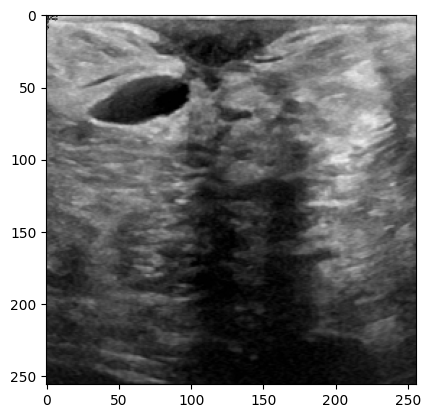

In [7]:
plt.imshow(data['image'][0])

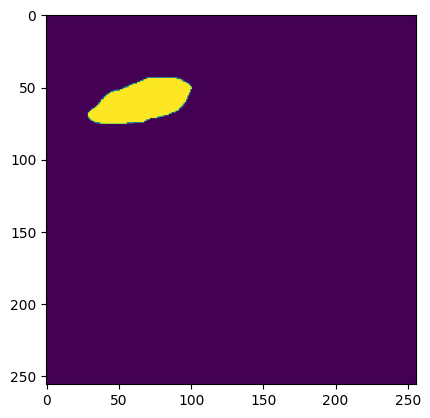

In [8]:
plt.imshow(data['mask'][0])

In [9]:
class Tumor(Dataset):
    def __init__(self, data):
        self.image = np.array(data['image'])
        self.mask= np.array(data['mask'])
    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = np.array(self.image[idx]).transpose(2,0,1)
        mask = np.array(self.mask[idx]).reshape(1,256,256)

        return img, mask

In [10]:
dataset = Tumor(data)

# Config

In [11]:
class CFG:
    random_seed = 42
    gated = True

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    

    batch_size = 32
    nEpochs = 10
    lr = 0.05


In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

In [14]:
torch.cuda.empty_cache()
gc.collect()

60

In [15]:
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

## Reproducibility

In [16]:
def set_seed(seed=CFG.random_seed):
    print(f"Seed: {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed()

Seed: 42


In [17]:
trainDL = DataLoader(dataset, batch_size=32,shuffle=True, pin_memory=True)

# Model

In [18]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        self.conv1 = Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = ReLU()
        self.conv2 = Conv2d(out_ch, out_ch, 3, padding=1)

        # init random weights
        nn.init.xavier_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)

        nn.init.xavier_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [19]:
class AutoEncoder(nn.Module):
    def __init__(self, channels = (3,32,64,128,256,512,1024)):
        super().__init__()
        self.channels = channels
        self.pool = MaxPool2d((2,2))

        self.encoder = nn.ModuleList([
            Block(channels[i], channels[i+1]) for i in range(len(channels)-1) # 1, 32, ..., 1024
        ])

    def forward(self, x):
        skip_out = []
        for block in self.encoder: # Goes through all blocks, passes through block and saves skip output
            x = block(x)
            skip_out.append(x)
            x = self.pool(x) # Reduces dim
        return skip_out

In [20]:
class AutoDecoder(nn.Module):
    def __init__(self, channels = (3,32,64,128,256,512,1024)):
        super().__init__()
        self.channels = channels[:0:-1] # Reverse of Encoder (Excluding First Unneeded in Output)
        self.pool = MaxPool2d((2,2))
        self.upconv = nn.ModuleList([
            ConvTranspose2d(self.channels[i], self.channels[i+1], 2, 2,padding=0) for i in range(len(self.channels)-1)
        ])

        self.decoder = nn.ModuleList([
            Block(self.channels[i], self.channels[i+1]) for i in range(len(self.channels)-1)
        ])

    def center_crop(self, x, enc_out): # Crop encoder output
        _, _, h, w = x.shape
        enc_out = CenterCrop([h,w])(enc_out)
        return enc_out
    
    def forward(self, x, enc_out:list):
        for i in range(len(self.channels)-1):
            x = self.upconv[i](x)
            enc_ftrs = self.center_crop(x, enc_out[i]) # Crop Skip
            x = torch.cat([x, enc_ftrs], dim=1) # Concatenate Decoder and Skip
            x = self.decoder[i](x)

            # Min Max Scaling [0,1]
            x = (x-x.min())/(x.max()-x.min())
        return x


In [21]:
class UNET(nn.Module):
    def __init__(self, channels = (3,64,128,256,512,1024)):
        super().__init__()

        # Encoder Path
        self.enc_path = AutoEncoder(channels)

        # Decoder Path
        self.dec_path = AutoDecoder(channels)

        self.out = Conv2d(channels[1], 1, 1)

        # init random weights
        nn.init.xavier_normal_(self.out.weight)
        nn.init.zeros_(self.out.bias)

    
    def forward(self, x):
        skips = self.enc_path(x)
        x = self.dec_path(skips[::-1][0], skips[::-1][1:]) 
        # Reverse of enc_out = upward path of decoder 
        #  [0] -> 1024 output
        # [1:] -> All other skip outputs
        x = self.out(x)
        # x = F.interpolate(x, (256,256))
        x = F.sigmoid(x)

        return x

In [22]:
model = UNET().to(CFG.device)

# Train

In [23]:
optim = AdamW(model.parameters(), lr=CFG.lr) # AdamW

## Dice Loss

Sørensen–Dice coefficient:
[Wikipedia](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
</br>
$${\displaystyle DSC={\frac {2|X\cap Y|}{|X|+|Y|}}}

In [24]:
class diceCoef(nn.Module):
    def init(self):
        super(diceCoef, self).init()

    def forward(self, inputs, targets, smooth=1):        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [25]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [26]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [27]:
criterion_dice = DiceBCELoss()

In [28]:
criterion_iou = IoULoss()

* Pixel Binary
* IOU
* BCE Dice

## Training Loop

In [29]:
history = {"train":[],
           "valid":[]}

In [30]:
model = UNET().to(CFG.device)
optim = AdamW(model.parameters(), lr=0.1)
trainDL = DataLoader(dataset, batch_size=8, shuffle=True)


In [32]:
model.train()
for e in range(CFG.nEpochs):
    print(f"[INFO] Epoch {e+1}/{CFG.nEpochs}")
    
    train_loss = 0
    dice_loss = 0
    iou_loss = 0
    for x,y in tqdm(trainDL):
        x, y = x.to(CFG.device).to(torch.float32), y.to(CFG.device).to(torch.float32)
        optim.zero_grad()
        pred = model(x)
        loss = criterion_dice(pred, y)
        loss.backward()
        optim.step()
        train_loss += loss

        
    avg_train_loss = train_loss/len(trainDL)
    
    print(f"Train Loss: {avg_train_loss}")

[INFO] Epoch 1/10


100%|██████████| 81/81 [00:41<00:00,  1.93it/s]


Train Loss: 1.5384304523468018
[INFO] Epoch 2/10


100%|██████████| 81/81 [00:41<00:00,  1.96it/s]


Train Loss: 1.5389404296875
[INFO] Epoch 3/10


100%|██████████| 81/81 [00:40<00:00,  1.98it/s]


Train Loss: 1.5389529466629028
[INFO] Epoch 4/10


100%|██████████| 81/81 [00:39<00:00,  2.03it/s]


Train Loss: 1.5384235382080078
[INFO] Epoch 5/10


100%|██████████| 81/81 [00:39<00:00,  2.04it/s]


Train Loss: 1.5390586853027344
[INFO] Epoch 6/10


100%|██████████| 81/81 [00:39<00:00,  2.04it/s]


Train Loss: 1.5391895771026611
[INFO] Epoch 7/10


100%|██████████| 81/81 [00:40<00:00,  2.02it/s]


Train Loss: 1.5383410453796387
[INFO] Epoch 8/10


100%|██████████| 81/81 [00:40<00:00,  2.00it/s]


Train Loss: 1.5387579202651978
[INFO] Epoch 9/10


100%|██████████| 81/81 [00:40<00:00,  2.00it/s]


Train Loss: 1.539252758026123
[INFO] Epoch 10/10


100%|██████████| 81/81 [00:40<00:00,  1.99it/s]


Train Loss: 1.5398833751678467


In [41]:
inference_img = torch.Tensor(dataset[0][0]).to(CFG.device).reshape(1,3,256,256)
inference_img.shape

torch.Size([1, 3, 256, 256])

In [54]:
inference = model(inference_img)
inference.shape

torch.Size([1, 1, 256, 256])

In [66]:
inf = inference.squeeze().detach().cpu().numpy()
inf2 = (inf-inf.min())/inf.max()

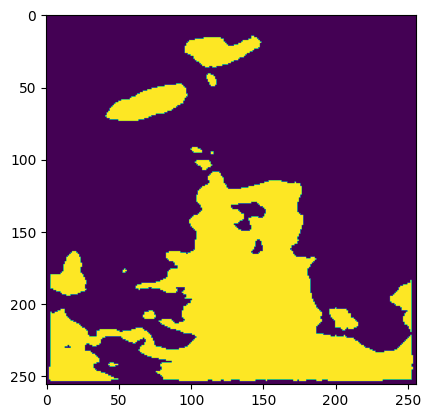

In [78]:
plt.imshow(inf2<0.00001)

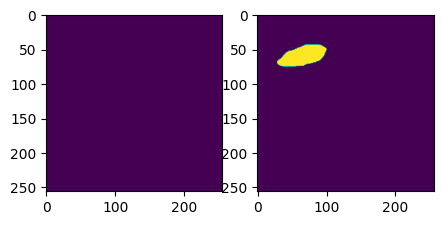

In [52]:
model.eval()
fig,ax = plt.subplots(1,2,figsize=(5,5))
ax[0].imshow(model(inference_img).detach().cpu().numpy().squeeze()>-1000)
ax[1].imshow(dataset[0][1].squeeze())

# Save Model

Create folder 


Models\\model_name\\

For Each Training
Models\\baseline_0\\baseline_0.pt

In [ ]:
if CFG.train_new:
    os.mkdir(f"Models/{CFG.model_name}")
    os.mkdir(f"Models/{CFG.model_name}/logs")

In [ ]:
# Save History as JSON
log_num = len(os.listdir(f"Models/{CFG.model_name}/logs"))
with open(f"Models/{CFG.model_name}/logs/log_{log_num}", "w") as out_path:
    json.dump(history, out_path)

TypeError: Object of type Tensor is not JSON serializable

In [ ]:
torch.save(model, f"Models/{CFG.model_name}/{CFG.model_name}.pt")

In [ ]:
CFG.model_name

'baseline_1'

# Notes

* Dropout
* Pixel Level Accuracy
* Single Conv in Block (Save Memory)
* Check Zoom
* 3D UNET